In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.stats.api as sms

from collections import namedtuple

from tqdm import tqdm, trange

import pystan

sns.set()
plt.rcParams['figure.figsize'] = [8.0, 6.0]

import arviz

In [2]:
%load_ext jupyterstan

# 1. Linear model: drowning data with Stan

In [3]:
data = np.loadtxt('data/drowning.txt')

Fixes: 

\#1 in line 14, the bound on sigma has been changed from upper to lower, since sigma has to be positive

\#2 in lines 20, 22, 32, the predictive model has been changed so that it extrapolates the trend estimated on the known data

In [5]:
%%stan model

data {
    int<lower=0> N; // number of data points
    vector[N] x; // observation year
    vector[N] y; // observation number of drowned
    real xpred; // prediction year
    real tau; // prior parameter
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma; // change 1
}


transformed parameters {
    vector[N] mu;
    real mu_pred;
    mu = alpha + beta * x;
    mu_pred = alpha + beta * xpred; // change 2
}

model {
    beta ~ normal(0, tau);
    y ~ normal(mu, sigma);
}

generated quantities {
    real ypred;
    ypred = normal_rng(mu_pred, sigma);
}


INFO:pystan:COMPILING THE C++ CODE FOR MODEL model_99f06b0226c8f4f054aa2f0c255dc13b NOW.


Creating pystan model & assigning it to variable name "model".
Stan options:
 {'model_name': 'model', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "model"!
Compilation took a minute.


In [4]:
tau = 26.78748933593304
dist = stats.norm(loc=0, scale=tau)
dist.interval(0.99)

(-69.0, 69.0)

The prior $\mathcal{N}(0, \tau^2)$ uses the value $\tau \approx 26.787$. It's implemented by adding a declaration `real tau` in line 8, and then setting the prior with `beta ~ normal(0, tau);` in line 26.

In [6]:
data_dict = {
    'N': data.shape[0],
    'x': data[:,0],
    'y': data[:,1],
    'xpred': 2019.,
    'tau': tau
}

fit = model.sampling(data=data_dict, control={'max_treedepth': 12}, iter=1000, chains=10, warmup=500, seed=2137)

samples = fit.extract()

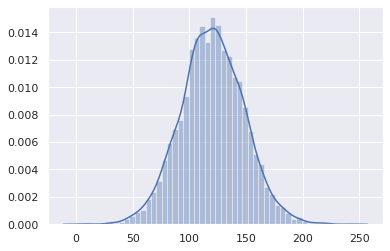

In [7]:
sns.distplot(samples['ypred'])

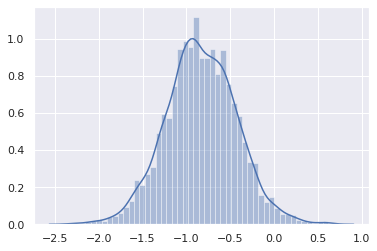

In [8]:
sns.distplot(samples['beta'])

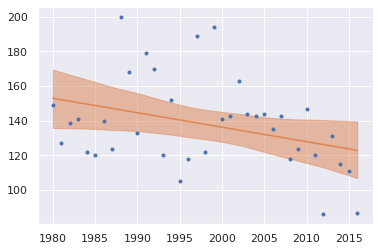

In [9]:
plt.plot(data[:,0], samples['mu'].mean(0), c='C1')
plt.plot(data[:,0], data[:,1], '.', c='C0')
arviz.plot_hpd(data[:,0], samples['mu'], credible_interval=0.95, color='C1', fill_kwargs={'alpha': 0.5}, plot_kwargs={'ls': '-.'})

# 2. Hierarchical model: factory data with Stan

In [5]:
factory_data = np.loadtxt('data/factory.txt')

In [8]:
factory_data.mean(0)

array([ 76. , 106.2,  87.8, 111.6,  90. ,  86. ])

## Separate

In [11]:
%%stan factory_separate

data {
    int<lower=0> N; // = 5 number of measurements per machine
    int<lower=0> M; // = 6 number of machines
    vector[N] y[M];
}

parameters {
    real mu[M];
    real<lower=0> sigma[M];
}

model {
    for (i in 1:M) {
        y[i] ~ normal(mu[i], sigma[i]);
    }
}

generated quantities {
    real ypred;
    ypred = normal_rng(mu[6], sigma[6]);
    
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL factory_separate_143b2fdf1f09a6089d36b8d6cb185010 NOW.


Creating pystan model & assigning it to variable name "factory_separate".
Stan options:
 {'model_name': 'factory_separate', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "factory_separate"!
Compilation took a minute.


In [12]:
separate_data = {
    'N': factory_data.shape[0],
    'M': factory_data.shape[1],
    'y': factory_data.T
}

In [13]:
fit_sep = factory_separate.sampling(data=separate_data, control={'max_treedepth': 12}, iter=1000, chains=10, warmup=500, seed=2137)

samples_sep = fit_sep.extract()

## i)

In the separate model, we can directly estimate the distribution and mean of the sixth machine:

Mean: 86.299


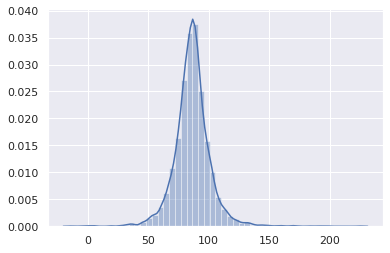

In [14]:
print(f"Mean: {samples_sep['mu'][:,5].mean():.3f}")
sns.distplot(samples_sep['mu'][:,5])  # i)
plt.show()

## ii)

The predictive distribution is again taken directly for the sixth machine

Mean: 85.95874311804856


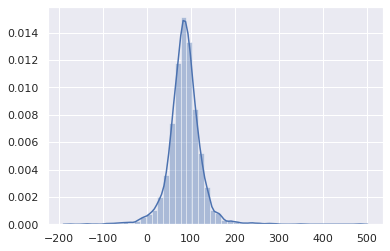

In [15]:
print(f"Mean: {samples_sep['ypred'].mean()}")
sns.distplot(samples_sep['ypred'])  # ii)
plt.show()

## iii)

In the separate model, the parameters are separate for each machine, so there is no way to estimate anything about a new machine.

## Pooled

In [16]:
%%stan factory_pooled

data {
    int<lower=0> N; // number of measurements total
    vector[N] y;
}

parameters {
    real mu;
    real<lower=0> sigma;
}

model {
    y ~ normal(mu, sigma);
}

generated quantities {
    real ypred;
    ypred = normal_rng(mu, sigma);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL factory_pooled_4769561310d69a5e48b54fe76fdc3520 NOW.


Creating pystan model & assigning it to variable name "factory_pooled".
Stan options:
 {'model_name': 'factory_pooled', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "factory_pooled"!
Compilation took a minute.


In [17]:
pooled_data = {
    'N': factory_data.ravel().shape[0],
    'y': factory_data.ravel()
}

In [18]:
fit_pool = factory_pooled.sampling(data=pooled_data, control={'max_treedepth': 12}, iter=1000, chains=10, warmup=500, seed=2137)

samples_pool = fit_pool.extract()

## i), iii)

In the pooled model, no distinction is made between differnet machines, so the posterior distribution of the mean is the same for any machine, specifically 6th and 7th

Mean: 92.96997392213457


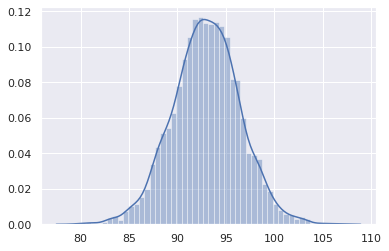

In [19]:
print(f"Mean: {samples_pool['mu'].mean()}")
sns.distplot(samples_pool['mu'])  # i), iii)

## ii)

The predictive distribution is the same for each machine, including the 6th one, taken directly from the simulation

Mean: 92.7357685467169


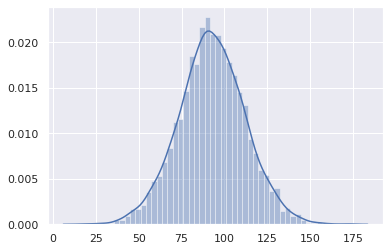

In [20]:
print(f"Mean: {samples_pool['ypred'].mean()}")
sns.distplot(samples_pool['ypred'])  # ii)

## Hierarchical

In [21]:
%%stan factory_hierarchical

data {
    int<lower=0> N; // = 5 number of measurements per machine
    int<lower=0> M; // = 6 number of machines
    vector[N] y[M];
}

parameters {
    vector[M] mu;
    real<lower=0> sigma;
    
    real mu_prior;
    real sigma_prior;
}

model {
    mu ~ normal(mu_prior, sigma_prior);
    for (i in 1:M) {
        y[i] ~ normal(mu[i], sigma);
    }
}

generated quantities {
    real ypred;
    real mu_new;
    ypred = normal_rng(mu[6], sigma);
    mu_new = normal_rng(mu_prior, sigma_prior);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL factory_hierarchical_2899bf3318e881102dd8d001cc036293 NOW.


Creating pystan model & assigning it to variable name "factory_hierarchical".
Stan options:
 {'model_name': 'factory_hierarchical', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "factory_hierarchical"!
Compilation took a minute.


In [22]:
hierarchical_data = {
    'N': factory_data.shape[0],
    'M': factory_data.shape[1],
    'y': factory_data.T
}

In [23]:
fit_h = factory_hierarchical.sampling(data=hierarchical_data, control={'max_treedepth': 12, 'adapt_delta': 0.999999}, iter=1000, chains=10, warmup=500, seed=2137)

samples_h = fit_h.extract()

## i)

In the hierarchical model, posterior mean distribution is different for each machine, so I'm choosing the simulation results for the 6th one.

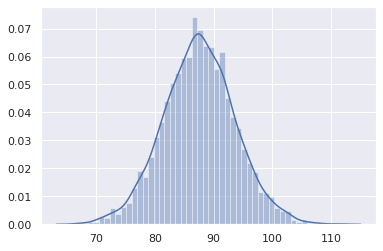

In [24]:
sns.distplot(samples_h['mu'][:,5])  # i)

## ii)

The predictive distribution for the 6th machine can be taken directly from the simulation

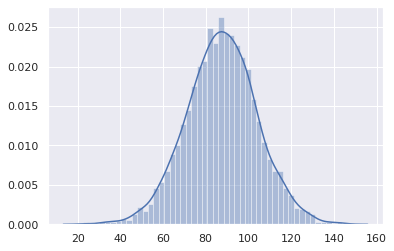

In [25]:
sns.distplot(samples_h['ypred'])  # ii)

## iii)

The mean distribution of a 7th machine can be estimated using the prior, with the parameters estimated from the first 6 machines. Since it's all handled by Stan, it can be taken directly from the simulation here.

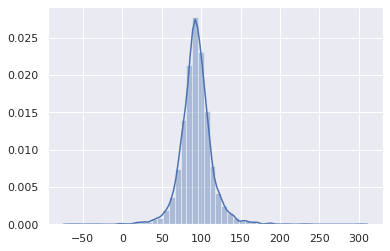

In [26]:
sns.distplot(samples_h['mu_new'])  # iii)